In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

from PIL import Image
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

%matplotlib inline

In [2]:
class MonetPhotoDataset(torch.utils.data.Dataset):
    def __init__(self, root_monet, root_photo, transform=None):
        self.transform = transform
        self.root_monet = root_monet
        self.root_photo = root_photo
        
        self.monet_images = os.listdir(root_monet)
        self.photo_images = os.listdir(root_photo)
        self.length_dataset = max(len(self.monet_images), len(self.photo_images))

        self.monet_len = len(self.monet_images)
        self.photo_len = len(self.photo_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):
        monet_img = self.monet_images[idx % self.monet_len]
        photo_img = self.photo_images[idx % self.photo_len]
        
        monet_path = os.path.join(self.root_monet, monet_img)
        photo_path = os.path.join(self.root_photo, photo_img)
        
        monet_img = Image.open(monet_path).convert('RGB')
        photo_img = Image.open(photo_path).convert('RGB')
    
        
        monet_img = self.transform(monet_img)
        photo_img = self.transform(photo_img)
        
        return monet_img, photo_img

In [3]:
class MonetDataset(torch.utils.data.Dataset):
    def __init__(self, root_monet, transform=None):
        self.transform = transform
        self.root_monet = root_monet
        
        self.monet_images = os.listdir(root_monet)

        self.monet_len = len(self.monet_images)

    def __len__(self):
        return self.monet_len

    def __getitem__(self, idx):
        monet_img = self.monet_images[idx % self.monet_len]
        
        monet_path = os.path.join(self.root_monet, monet_img)
        
        monet_img = Image.open(monet_path).convert('RGB')
        
        monet_img = self.transform(monet_img)
        
        return monet_img

In [4]:
class PhotoDataset(torch.utils.data.Dataset):
    def __init__(self, root_photo, transform=None):
        self.transform = transform
        self.root_photo = root_photo
        
        self.photo_images = os.listdir(root_photo)
        
        self.photo_len = len(self.photo_images)

    def __len__(self):
        return self.photo_len

    def __getitem__(self, idx):
        photo_img = self.photo_images[idx % self.photo_len]

        photo_path = os.path.join(self.root_photo, photo_img)

        photo_img = Image.open(photo_path).convert('RGB')

        photo_img = self.transform(photo_img)
        
        return photo_img

In [5]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [6]:
dataset = MonetPhotoDataset('../input/gan-getting-started/monet_jpg', '../input/gan-getting-started/photo_jpg', transform=transform)
monet_dataset = MonetDataset('../input/gan-getting-started/monet_jpg', transform=transform)
photo_dataset = PhotoDataset('../input/gan-getting-started/photo_jpg', transform=transform)

In [7]:
len(dataset)

7038

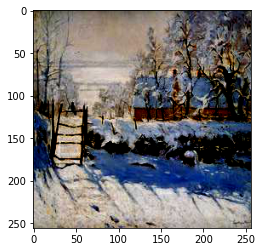

In [8]:
x = monet_dataset[10]
x = x.permute(1, 2, 0)

plt.imshow(x.numpy())

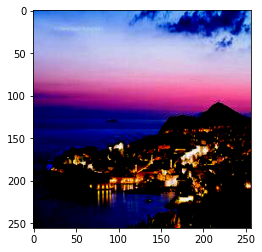

In [9]:
y = photo_dataset[1]
y = y.permute(1, 2, 0)
#y = (y * 0.5) + 0.5
plt.imshow(y.numpy())

In [10]:
# Checking if GPU is enabled
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Generator

In [11]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=6):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(1*f), nn.LeakyReLU(0.2),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.LeakyReLU(0.2),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.LeakyReLU(0.2)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.LeakyReLU(0.2),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

Discriminator

In [12]:
nc=3
ndf=64
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf*8,1,4,1,1)
            # state size. 1 x 14 x 14
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# tmp_discriminator = Discriminator()
# tmp_discriminator = tmp_discriminator.to(device)

# tmp_generator = Generator(f=64, blocks=6)
# tmp_generator = tmp_generator.to(device)

In [14]:
# !pip install torch-summary

In [15]:
# from torchsummary import summary

# summary(tmp_discriminator, (3,256,256))

In [16]:
# summary(tmp_generator, (3,256,256))

In [17]:
monet_batch_size = 1
photo_batch_size = 1

monet_train_dl = torch.utils.data.DataLoader(monet_dataset, monet_batch_size, shuffle=True, num_workers=2, pin_memory=True)
photo_train_dl = torch.utils.data.DataLoader(photo_dataset, photo_batch_size, shuffle=True, num_workers=2, pin_memory=True)

combined_train_dl = torch.utils.data.DataLoader(dataset, photo_batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [18]:
monet_generator = Generator(f=64, blocks=6) # transforms photos to Monet
monet_generator = monet_generator.to(device)
photo_generator = Generator(f=64, blocks=6) # transforms Monet to photos
photo_generator = photo_generator.to(device)

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
monet_discriminator = monet_discriminator.to(device)
photo_discriminator = Discriminator() # differentiates real photos and generated photos
photo_discriminator = photo_discriminator.to(device)

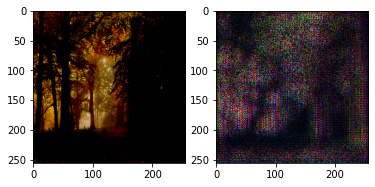

In [19]:
y = photo_dataset[0]
y = y.to(device)

generated_y = monet_generator(y)

plt.subplot(1, 2, 1)
y = y.permute(1, 2, 0)
plt.imshow(y.cpu().numpy())

plt.subplot(1, 2, 2)
generated_y = generated_y.permute(1,2,0)
plt.imshow(generated_y.cpu().detach().numpy())

In [20]:
def Discriminator_loss_fn(real, fake):
    return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def Generator_loss_fn(fake):
    return  torch.mean((fake - 1)**2)

def Cycle_consistency_loss_fn(real, returned, lambda_val):
    loss = torch.mean(torch.abs(real - returned))
    return lambda_val * loss

def Identity_loss_fn(real, same, lambda_val):
    loss = torch.mean(torch.abs(real - same))
    return lambda_val * loss

In [21]:
#Define loss functions later
def fit(epochs, lr, lambda_val):
    torch.cuda.empty_cache()
    
    monet_generator.train()
    photo_generator.train()
    monet_discriminator.train()
    photo_discriminator.train()
    
    m_gen_opt = torch.optim.Adam(monet_generator.parameters(), lr=lr, betas=(0.50, 0.8))
    p_gen_opt = torch.optim.Adam(photo_generator.parameters(), lr=lr, betas=(0.50, 0.8))
    m_disc_opt = torch.optim.Adam(monet_discriminator.parameters(), lr=lr, betas=(0.50, 0.8))
    p_disc_opt = torch.optim.Adam(photo_discriminator.parameters(), lr=lr, betas=(0.50, 0.8))
    
    for epoch in range(epochs):
        real_monet = monet_dataset[0]
        real_photo = photo_dataset[0]
        index = 0
        for monet_batch, photo_batch in tqdm(combined_train_dl):
            real_monet = monet_batch
            real_monet = real_monet.to(device)
            real_photo = photo_batch
            real_photo = real_photo.to(device)
            
            # Real photo to Monet to Photo
            fake_monet = monet_generator(real_photo)
            returned_photo = photo_generator(fake_monet)
            
            # Real Monet to Photo to Monet
            fake_photo = photo_generator(real_monet)
            returned_monet = monet_generator(fake_photo)
            
            # Real Monet to Monet and Real Photo to Photo
            identity_monet = monet_generator(real_monet)
            identity_photo = photo_generator(real_photo)
            
            #Dsicriminator checking real Monet and Photos
            d_real_monet = monet_discriminator(real_monet)
            d_real_photo = photo_discriminator(real_photo)
            
            #Discriminator checking fake Monet and Photos
            d_fake_monet = monet_discriminator(fake_monet)
            d_fake_photo = photo_discriminator(fake_photo)
            
            #Generator loss
            monet_gen_loss = Generator_loss_fn(d_fake_monet)
            photo_gen_loss = Generator_loss_fn(d_fake_photo)
            
            #Discriminator loss
            monet_disc_loss = Discriminator_loss_fn(d_real_monet, d_fake_monet)
            photo_disc_loss = Discriminator_loss_fn(d_real_photo, d_fake_photo)
            
            #Cycle consistency loss
            total_cycle_loss = Cycle_consistency_loss_fn(real_monet, returned_monet, lambda_val) + Cycle_consistency_loss_fn(real_photo, returned_photo, lambda_val)
            
            #Total generator loss
            total_monet_g_loss = monet_gen_loss + total_cycle_loss + Identity_loss_fn(real_monet, identity_monet, lambda_val)
            total_photo_g_loss = photo_gen_loss + total_cycle_loss + Identity_loss_fn(real_photo, identity_photo, lambda_val)
            
            m_gen_opt.zero_grad()
            p_gen_opt.zero_grad()
            m_disc_opt.zero_grad()
            p_disc_opt.zero_grad()
            
            total_monet_g_loss.backward(retain_graph=True)            
            total_photo_g_loss.backward(retain_graph=True)
            monet_disc_loss.backward(retain_graph=True)
            photo_disc_loss.backward()
            
            m_gen_opt.step()
            p_gen_opt.step()
            m_disc_opt.step()
            p_disc_opt.step()
            
            index += 1
            
            if index % 1500 == 0:
                print("Monet G Loss {:.4f}, Monet D Loss {:.4f}, Photo G Loss {:.4f}, Photo D Loss {:.4f}, CycleLoss {:.4f}".format(
                total_monet_g_loss, monet_disc_loss, total_photo_g_loss, photo_disc_loss, total_cycle_loss))

In [22]:
fit(epochs=1, lr=2e-4, lambda_val=10)

  0%|          | 0/7038 [00:00<?, ?it/s]

Monet G Loss 8.2414, Monet D Loss 0.2093, Photo G Loss 6.4120, Photo D Loss 0.3042, CycleLoss 4.6730
Monet G Loss 5.3980, Monet D Loss 0.2226, Photo G Loss 7.4122, Photo D Loss 0.2546, CycleLoss 3.9255
Monet G Loss 6.3150, Monet D Loss 0.2288, Photo G Loss 7.9490, Photo D Loss 0.2472, CycleLoss 4.6181
Monet G Loss 8.7873, Monet D Loss 0.2545, Photo G Loss 8.0575, Photo D Loss 0.2589, CycleLoss 6.0830


In [23]:
def displayImagesPtoM(left, right):
    _, ax = plt.subplots(right-left+1, 2, figsize=(12, 12))
    monet_generator.eval()

    for i,photo_image in enumerate(photo_dataset):
        if i > right:
            break
        if i < left:
            continue
        photo_image = photo_image.to(device)
        generated_image = monet_generator(photo_image)

        photo_image = photo_image.permute(1, 2, 0)
        photo_image = photo_image.cpu().numpy()

        generated_image = generated_image.permute(1,2,0)
        generated_image = generated_image.cpu().detach().numpy()
        
        photo_image = (photo_image * 0.5) + 0.5
        generated_image = (generated_image * 0.5) + 0.5

        ax[i-left, 0].imshow(photo_image)
        ax[i-left, 1].imshow(generated_image)
        ax[i-left, 0].set_title("Input Photo")
        ax[i-left, 1].set_title("Monet-esque")
        ax[i-left, 0].axis("off")
        ax[i-left, 1].axis("off")

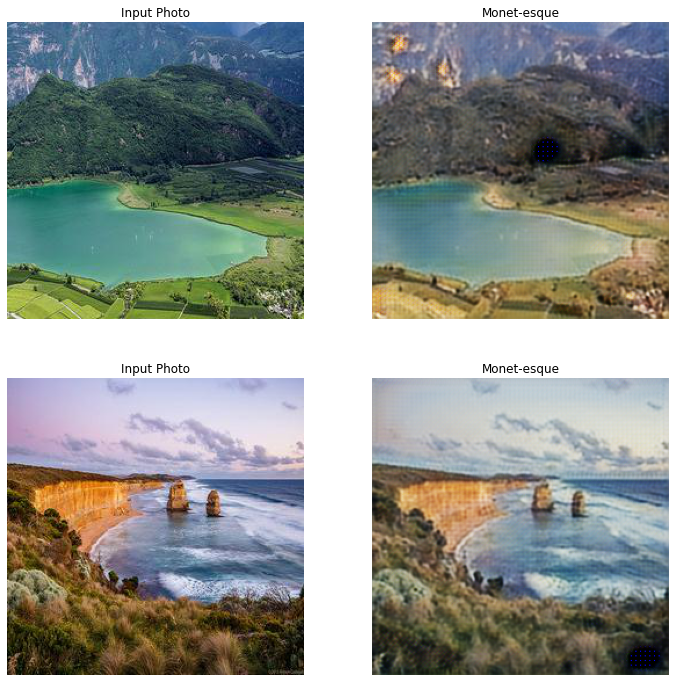

In [24]:
displayImagesPtoM(10,11)

In [25]:
def displayImagesMtoP(left, right):
    photo_generator.eval()
    _, ax = plt.subplots(right-left+1, 2, figsize=(12, 12))

    for i,monet_image in enumerate(monet_dataset):
        if i > right:
            break
        if i < left:
            continue
        monet_image = monet_image.to(device)
        generated_image = photo_generator(monet_image)

        monet_image = monet_image.permute(1, 2, 0)
        monet_image = monet_image.cpu().numpy()

        generated_image = generated_image.permute(1,2,0)
        generated_image = generated_image.cpu().detach().numpy()
        
        monet_image = (monet_image * 0.5) + 0.5
        generated_image = (generated_image * 0.5) + 0.5

        ax[i-left, 0].imshow(monet_image)
        ax[i-left, 1].imshow(generated_image)
        ax[i-left, 0].set_title("Monet-esque")
        ax[i-left, 1].set_title("Input Photo")
        ax[i-left, 0].axis("off")
        ax[i-left, 1].axis("off")

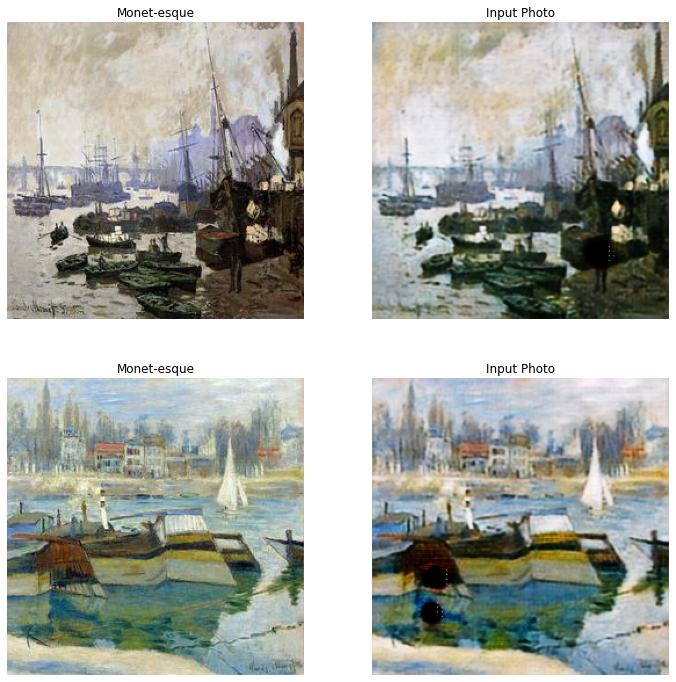

In [26]:
displayImagesMtoP(50,51)

In [27]:
! mkdir ../images

In [28]:
# import os
# os.remove("/kaggle/working/images1.zip")

In [29]:
# import shutil
# shutil.rmtree("../images")

In [30]:
# print(len(photo_dataset))

In [31]:
for i in range(len(photo_dataset)):
    img = photo_dataset[i]
    img = img.to(device)
    monet_generator.eval()
    prediction = monet_generator(img)
    prediction = prediction.permute(1,2,0)
    prediction = prediction.cpu().detach().numpy()
    prediction = ((prediction * 127.5) + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save("../images/" + str(i+1) + ".jpg")
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000


In [32]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

In [ ]:
img = photo_dataset[1000]
img = img.to(device)
monet_generator.eval()
prediction = monet_generator(img)
prediction = prediction.permute(1,2,0)
prediction = prediction.cpu().detach().numpy()
plt.imshow(prediction)
prediction = (prediction * 255).astype(np.uint8)

In [ ]:
# torch.save(monet_generator.state_dict(), "monet_gen.pth")
# torch.save(photo_generator.state_dict(), "photo_gen.pth")
# torch.save(monet_discriminator.state_dict(), "monet_disc.pth")
# torch.save(photo_discriminator.state_dict(), "photo_disc.pth")

In [ ]:
# c1 = torch.load("../input/cyclegan-implementation/monet_gen.pth")
# c2 = torch.load("../input/cyclegan-implementation/photo_gen.pth")
# c3 = torch.load("../input/cyclegan-implementation/monet_disc.pth")
# c4 = torch.load("../input/cyclegan-implementation/photo_disc.pth")

In [ ]:
# monet_generator.load_state_dict(c1)
# photo_generator.load_state_dict(c2)
# monet_discriminator.load_state_dict(c3)
# photo_discriminator.load_state_dict(c4)